## Blight Ticket Compliance Prediction 

### Submitted To:
### Vahid Hadavi
### AML-2203 Advanced Python AI ML Tools

### Submitted By:

### Arathy Ajith (C0790836)
### Jibin John (C0796674)
### Nidhi Parmar (C0796680)
### Rincy Jose (C0790298)
### Taranpreet Kaur (C0793771)

In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc, plot_roc_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

### Loading the dataset

In [2]:
path = 'C:\\Users\\lenovo\\PycharmProjects\\Second sem\\Advanced python\\assignment 2\\Blight_Violations.csv'
path1 = 'F:\\AIMT\\Sem 2\\AML-2203 Adv Python\\Blight_Violations_Final.csv'
Dataset = pd.read_csv(path1)

C:\Users\jibin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9,11,15,16,17,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# General view of the raw data
print(Dataset.shape)
(Dataset.head())

(501689, 41)


,X,Y,ticket_id,ticket_number,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,violation_address,parcelno,oid
0,-83.072573,42.383350,18645,05001700DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Dean Byrd,601,KING,NaN,...,NaN,280.0,NaN,280.0,NaN,NaN,NaN,601 KING,03002390.,18645
1,-83.072479,42.383394,18646,05001701DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Cynthia Roberts,607,KING,NaN,...,NaN,0.0,0.0,0.0,NaN,NO PAYMENT DUE,NaN,607 KING,03002391.,18646
2,-83.115061,42.359916,18648,05001703DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Dannny Barnes,4066,COLUMBUS,NaN,...,NaN,0.0,0.0,0.0,NaN,NO PAYMENT DUE,NaN,4066 COLUMBUS,14002572.,18648
3,-83.128041,42.393448,18649,05001704DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Gloria Seldon,3005,PASADENA,NaN,...,NaN,0.0,0.0,0.0,NaN,NO PAYMENT DUE,NaN,3005 PASADENA,12004708.,18649
4,NaN,NaN,18650,05001705DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Bessie Thomas,4024,CLEMENTS,NaN,...,NaN,0.0,0.0,0.0,NaN,NO PAYMENT DUE,NaN,4024 CLEMENTS,NaN,18650


### Data pre processing 

In [4]:
# There are quite number of redundant columns which have either no data or no meaningful information
# Lets check those columns
Dataset.isna().sum()

X                             191874
Y                             191874
ticket_id                          0
ticket_number                      0
agency_name                        0
inspector_name                     0
violator_name                      2
violation_street_number            0
violation_street_name             65
violation_zip_code            342535
violator_id                        0
mailing_address_str_number         6
mailing_address_str_name          11
city                            3334
state                           3797
zip_code                        3337
non_us_str_code               498352
country                       498341
violation_date                     0
ticket_issued_time                 0
hearing_date                       1
hearing_time                      13
judgment_date                  17024
violation_code                     2
violation_description              2
disposition                        0
fine_amount                        2
a

In [5]:
# X and Y columns are irrelevatnt data, also column cleanup_cost amount, payment_amount columns have abosolutely no data
Dataset = Dataset.drop(['X','Y'],axis =1)
Dataset.shape

(501689, 39)

Since we need to find the whether a person will be compliant or not, we need to train our model with data which contains people who were found guilty


In [6]:
Dataset.disposition.unique()

array(['Responsible by Default', 'Not responsible by City Dismissal',
       'Not responsible by Dismissal', 'Responsible by Admission',
       'Responsible by Determination', 'Not responsible by Determination',
       'by', 'PENDING', 'Responsible (Fine Waived) by Determination',
       'Responsible (Fine Waived) by Admission',
       'Responsible - Compl/Adj by Default',
       'Responsible - Compl/Adj by Determination',
       'Responsible by Dismissal',
       'Responsible (Fine Waived) by City Dismissal', 'Responsible by',
       'by Default'], dtype=object)

The disposition terms 'by', 'by Default' and 'Responsible by' seems ambiguous
 Lets check the data for these instances 

In [7]:
#For disposition 'Responsible by'
Dataset[Dataset['disposition'] == 'Responsible by'] 

,ticket_id,ticket_number,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,violator_id,mailing_address_str_number,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,violation_address,parcelno,oid
485178,528854,20024218DAH,"Buildings, Safety Engineering & Env Department",Kenneth Potenga,PRINCESS HAMPTON,15624,BRINGARD DR,48205,495303,26375,...,NaN,530.0,NaN,530.0,NaN,NaN,NaN,15624 BRINGARD DR,NaN,528854
487085,530959,20030065DAH,BSEED Environmental Affairs,Haseen Neal,GERALD REYES,15429,RUTHERFORD,48227,497408,10808,...,NaN,130.0,NaN,130.0,NaN,NaN,NaN,15429 RUTHERFORD,22056487.,530959


In [8]:
#For disposition 'by Default'
Dataset[Dataset['disposition'] == 'by Default'] 

,ticket_id,ticket_number,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,violator_id,mailing_address_str_number,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,violation_address,parcelno,oid
497858,542530,21010268DAH,"Buildings, Safety Engineering & Env Department",Andrew DeRamer,KELLY MISNER,14420,EASTWOOD,NaN,508979,17300,...,NaN,530.0,NaN,530.0,NaN,NaN,NaN,14420 EASTWOOD,21019427.,542530


In [9]:
#For disposition 'by'
Dataset[Dataset['disposition'] == 'by'] 

,ticket_id,ticket_number,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,violator_id,mailing_address_str_number,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,violation_address,parcelno,oid
27,18673,05002105DAH,"Buildings, Safety Engineering & Env Department",Claude O'Neal,JOHNS GRILL,10534,CHICAGO,NaN,1991,10534,...,NaN,280.0,NaN,280.0,NaN,NaN,NaN,10534 CHICAGO,18005613.,18673
43,18690,05001716DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Yoland Adams,7111,SEVEN MILE,NaN,1630,18665,...,NaN,280.0,NaN,280.0,NaN,NaN,NaN,7111 SEVEN MILE,NaN,18690
59,18706,05001928DAH,"Buildings, Safety Engineering & Env Department",Delos Matthews,columbus coney island,5414,VERNOR,NaN,1815,5414,...,NaN,280.0,NaN,280.0,NaN,NaN,NaN,5414 VERNOR,16000767.,18706
85,18737,05003136DAH,"Buildings, Safety Engineering & Env Department",Darrin Williams,Poi Pointe Services LTD,18701,MACK,NaN,2945,18701,...,NaN,130.0,NaN,130.0,2005/02/18 15:55:00+00,PAID IN FULL,NaN,18701 MACK,21001638-57,18737
308,18974,05003147DAH,"Buildings, Safety Engineering & Env Department",Darrin Williams,Robert Gott,9313,VAN DYKE,NaN,2956,2075,...,NaN,705.0,NaN,705.0,2005/02/11 16:15:00+00,NaN,NaN,9313 VAN DYKE,15005589-90,18974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501684,546586,21028749DAH,BSEED Environmental Affairs,Billy Jones,TPIBV LLC,12933,DWYER,48212,513035,9050,...,NaN,230.0,NaN,230.0,NaN,NaN,NaN,12933 DWYER,13012115.,546586
501685,546587,21024087DAH,"Buildings, Safety Engineering & Env Department",Tanzil Coleman,Raejine Wright,14310,METTETAL,48227,513036,20166,...,NaN,530.0,NaN,530.0,NaN,NaN,NaN,14310 METTETAL,NaN,546587
501686,546588,21024088DAH,"Buildings, Safety Engineering & Env Department",Tanzil Coleman,Jeanette Avila,2002,CENTRAL,48209,513037,7286,...,NaN,280.0,NaN,280.0,NaN,NaN,NaN,2002 CENTRAL,18009661.,546588
501687,546589,21024089DAH,"Buildings, Safety Engineering & Env Department",Tanzil Coleman,Jeanette Avila,2002,CENTRAL,48209,513038,7286,...,NaN,280.0,NaN,280.0,NaN,NaN,NaN,2002 CENTRAL,18009661.,546589


In [10]:
# Code for checking the data for 'by' cases

print(Dataset[Dataset['disposition'] == 'by'].shape)
Dataset[Dataset['disposition'] == 'by'].isnull().sum()

(17024, 39)


ticket_id                         0
ticket_number                     0
agency_name                       0
inspector_name                    0
violator_name                     0
violation_street_number           0
violation_street_name            22
violation_zip_code             1585
violator_id                       0
mailing_address_str_number        0
mailing_address_str_name          1
city                            187
state                           187
zip_code                        187
non_us_str_code               16837
country                       16837
violation_date                    0
ticket_issued_time                0
hearing_date                      1
hearing_time                     13
judgment_date                 17024
violation_code                    0
violation_description             0
disposition                       0
fine_amount                       0
admin_fee                         0
state_fee                         0
late_fee                    

From the above code, it can be clearly stated that all cases having  disposition as 'by' have no judgement date, therefore the records seems ambiguous for analysis

Therefore, the dataset needs to be filterd for only those who are held responsible

In [11]:
cases = ['Responsible by Default',
        'Responsible by Admission',
       'Responsible by Determination',
       'Responsible (Fine Waived) by Determination',
       'Responsible (Fine Waived) by Admission',
       'Responsible - Compl/Adj by Default',
       'Responsible - Compl/Adj by Determination',
       'Responsible by Dismissal',
       'Responsible (Fine Waived) by City Dismissal']

Compliant_dataset = Dataset.loc[Dataset['disposition'].isin(cases)] 
Compliant_dataset.shape

(274946, 39)

The next task is to define whether a person is compliant or not

For that, following conditions must be applicale for a person to be compliant:
* The person pays fine within 6 months after judgement date
* The person pays full amount for fine
* The person pays fine prior to judgement (By own admission)



In [12]:
conditions = [
    ((Compliant_dataset['payment_status'] == 'NO PAYMENT DUE')
     | ((Compliant_dataset['payment_status'] == 'PAID IN FULL') & (pd.to_datetime(Compliant_dataset['payment_date']).dt.to_period('M').astype(int) - pd.to_datetime(Compliant_dataset['judgment_date']).dt.to_period('M').astype(int)  <= 6))),
    ((Compliant_dataset['payment_status'] == 'PARTIAL PAYMENT APPLIED') | (Compliant_dataset['payment_status'] =='NO PAYMENT APPLIED')
     | (pd.isna(Compliant_dataset['payment_status']) == True) | (Compliant_dataset['payment_status'].isnull() == True) | (pd.to_datetime(Compliant_dataset['payment_date']).dt.to_period('M').astype(int) - pd.to_datetime(Compliant_dataset['judgment_date']).dt.to_period('M').astype(int)  > 6))
       ]

# create a list of the values we want to assign for each condition
values = ['Compliant', 'Non_Compliant']

# create a new column and use np.select to assign values to it using our lists as arguments
Compliant_dataset['Compliance'] = np.select(conditions, values)

# display updated DataFrame
Compliant_dataset.head()

C:\Users\jibin\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
<ipython-input-12-051500f02411>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Compliant_dataset['Compliance'] = np.select(conditions, values)


,ticket_id,ticket_number,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,violator_id,mailing_address_str_number,...,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,violation_address,parcelno,oid,Compliance
0,18645,05001700DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Dean Byrd,601,KING,NaN,1614,599,...,280.0,NaN,280.0,NaN,NaN,NaN,601 KING,03002390.,18645,Non_Compliant
6,18652,05001707DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Aljay Adams,3395,PALMER,NaN,1621,3387,...,280.0,NaN,280.0,NaN,NaN,NaN,3395 PALMER,13003490.,18652,Non_Compliant
7,18653,05001708DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,na Garden Court Apt.s,2900,JEFFERSON,NaN,1622,2900,...,280.0,NaN,280.0,2005/02/22 08:43:00+00,PAID IN FULL,NaN,2900 JEFFERSON,11000088.014,18653,Compliant
8,18654,05001709DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,na JMC Manag.,69,SEWARD,NaN,1623,463012,...,280.0,NaN,280.0,NaN,NaN,NaN,69 SEWARD,02001187.,18654,Non_Compliant
9,18655,05001710DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Clairwood Apt.s,100,CLAIRMOUNT,NaN,1624,784,...,280.0,55.0,225.0,2020/01/23 00:00:00+00,PARTIAL PAYMENT APPLIED,NaN,100 CLAIRMOUNT,02001430.,18655,Non_Compliant


In [13]:
Compliant_dataset.shape

(274946, 40)

#### Handling the missing values

In [14]:
# Handle missing values
Compliant_dataset.isnull().sum()

ticket_id                          0
ticket_number                      0
agency_name                        0
inspector_name                     0
violator_name                      0
violation_street_number            0
violation_street_name             17
violation_zip_code            172624
violator_id                        0
mailing_address_str_number         3
mailing_address_str_name           7
city                            2471
state                           2743
zip_code                        2473
non_us_str_code               272474
country                       272469
violation_date                     0
ticket_issued_time                 0
hearing_date                       0
hearing_time                       0
judgment_date                      0
violation_code                     2
violation_description              2
disposition                        0
fine_amount                        2
admin_fee                          0
state_fee                          0
l

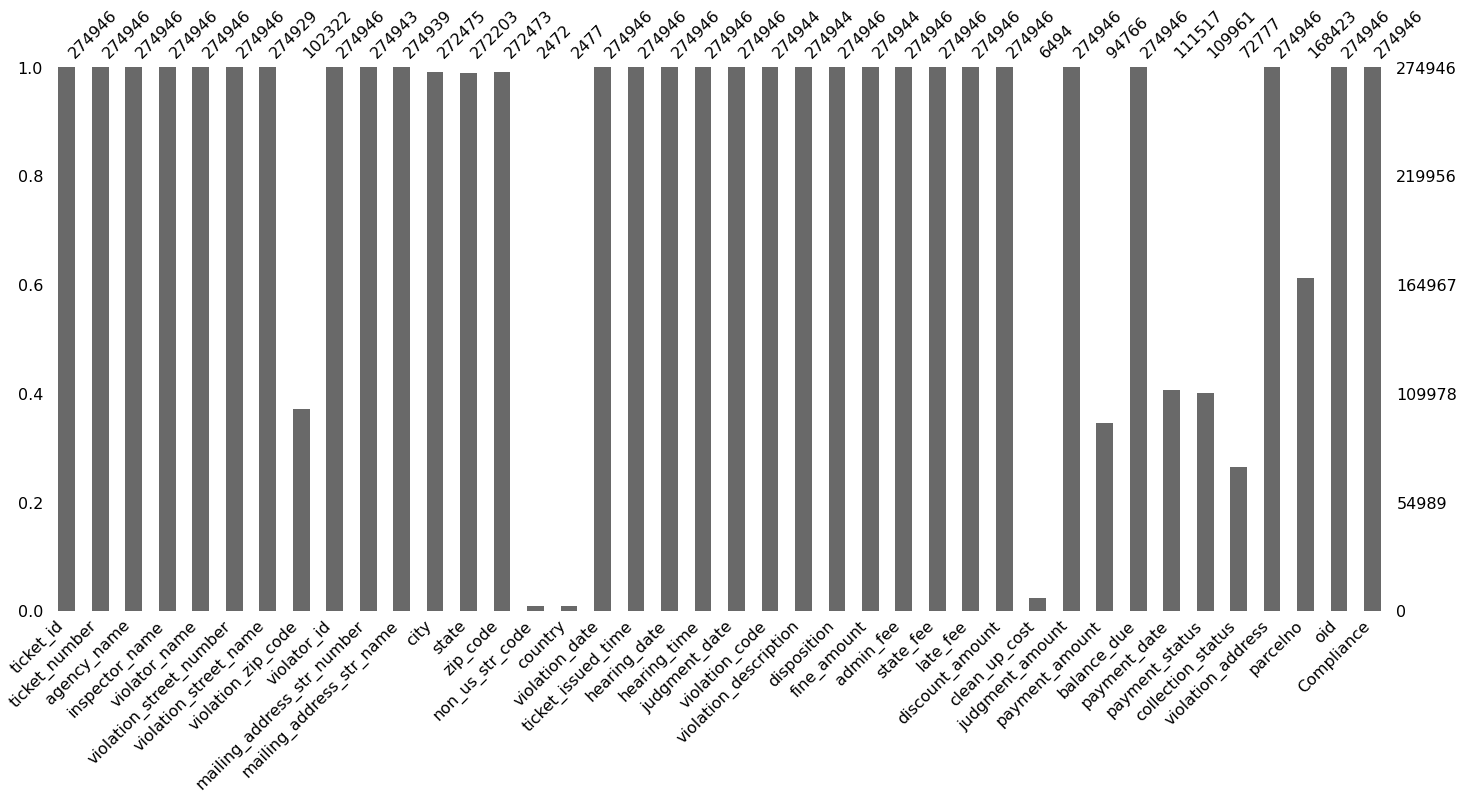

In [15]:
# check the missing value by bar chart

msno.bar(Compliant_dataset)

#### It can be seen in the graph that some features has very less values, we can remove those features/columns.

In [16]:
# removing the features having very less values 
#Also removing keys (Primary keys such as ticket_id) 
Compliant_dataset_new =  Compliant_dataset.drop(['ticket_id','ticket_number',"violation_zip_code", "non_us_str_code", "country", "payment_amount",
                                                 "collection_status", "parcelno", "clean_up_cost",'oid'], axis=1)

In [17]:
# again check the missing values 
Compliant_dataset_new.isnull().sum()

agency_name                        0
inspector_name                     0
violator_name                      0
violation_street_number            0
violation_street_name             17
violator_id                        0
mailing_address_str_number         3
mailing_address_str_name           7
city                            2471
state                           2743
zip_code                        2473
violation_date                     0
ticket_issued_time                 0
hearing_date                       0
hearing_time                       0
judgment_date                      0
violation_code                     2
violation_description              2
disposition                        0
fine_amount                        2
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
judgment_amount                    0
balance_due                        0
payment_date                  163429
p

Now only payment_date and payment_status have large missing values.
As these attributes are important, we can't remove them directly. 

There are cases where payment is not made and the status due to which is null , therefore payment_date will also be null,let replace those payment_date to year 2099

In [18]:
# Removing payment_date will null values for valid payment status
Compliant_dataset_new = Compliant_dataset_new.drop(Compliant_dataset_new[(Compliant_dataset_new['payment_date'].isnull() == False ) & (Compliant_dataset_new['payment_status'].isnull() == True)].index)
# For Compliant records with no payment due, replacing the payment date with judgment date
Compliant_dataset_new.loc[Compliant_dataset_new['payment_status'] =='NO PAYMENT DUE', 'payment_date'] = Compliant_dataset_new['judgment_date']


For the remaining payment status is null because no payment is done for non compliant, so replacing the null with 'No payment date'. Similarly, for payment_date we are filling with 2099 year and will consider this year as a representation for non compliance date

In [19]:
Compliant_dataset_new["payment_status"].fillna("NO PAYMENT MADE", inplace = True)
Compliant_dataset_new["payment_date"].fillna("2099/12/12 00:00:00+00", inplace = True)

In [20]:
#Dumping the value for remaining nul records
Compliant_dataset_new = Compliant_dataset_new.dropna()

In [21]:
Compliant_dataset_new.isnull().sum()

agency_name                   0
inspector_name                0
violator_name                 0
violation_street_number       0
violation_street_name         0
violator_id                   0
mailing_address_str_number    0
mailing_address_str_name      0
city                          0
state                         0
zip_code                      0
violation_date                0
ticket_issued_time            0
hearing_date                  0
hearing_time                  0
judgment_date                 0
violation_code                0
violation_description         0
disposition                   0
fine_amount                   0
admin_fee                     0
state_fee                     0
late_fee                      0
discount_amount               0
judgment_amount               0
balance_due                   0
payment_date                  0
payment_status                0
violation_address             0
Compliance                    0
dtype: int64

#### To understand the recent trends and patterns, the dataset is been filtered for violations occured from 2018

In [22]:

Compliant_dataset_new=Compliant_dataset_new.loc[(Compliant_dataset_new['violation_date'] >= '2018-01-01')]

In [23]:
Compliant_dataset_new.shape

(79597, 30)

## Visualizations

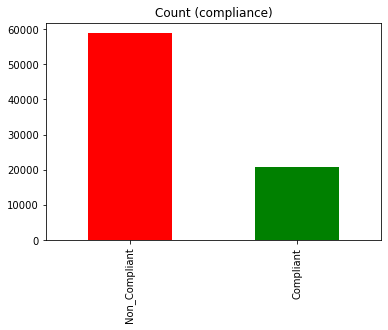

In [25]:
# Count of Non-Compliance vs Compliance in the dataset

Compliant_dataset_new.Compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green']);

In [26]:
# Creating a dataset to check how many non compliants pay their fine in upcoming months (i.e after the period of 6 months)

import datetime
Compliant_dataset_new['month_gap']= (pd.to_datetime(Compliant_dataset['payment_date']).dt.to_period('M').astype(int) - pd.to_datetime(Compliant_dataset['judgment_date']).dt.to_period('M').astype(int))
C = Compliant_dataset_new.loc[(Compliant_dataset_new['month_gap'] > 6)  & (Compliant_dataset_new['month_gap'] < 100)]
C = C.loc[C['payment_status'] =='PAID IN FULL']


C:\Users\jibin\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Text(0, 0.5, 'Non_compliant who paid fines')

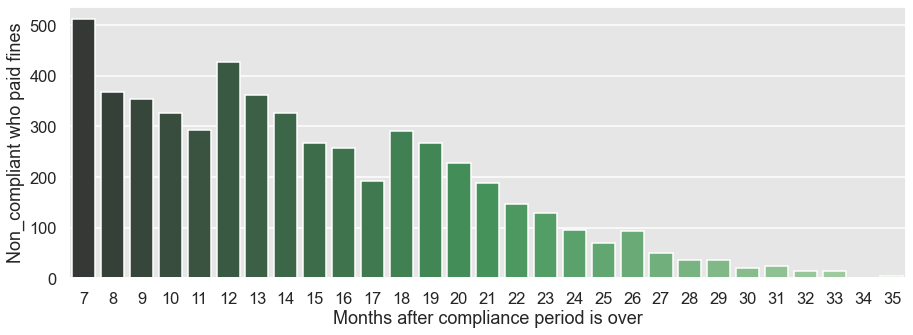

In [33]:
plt.figure(figsize = (15,5))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
#sns.axes_style('white')
sns.set_context("talk")
sns.countplot(x="month_gap", data=C,palette="Greens_d")
plt.xlabel('Months after compliance period is over')
plt.ylabel('Non_compliant who paid fines')

In [35]:
# Checking ratio of compliance if discount is provided 
D = Compliant_dataset_new.loc[(Compliant_dataset_new['discount_amount'] > 0)]
E =Compliant_dataset_new.loc[(Compliant_dataset_new['discount_amount'] == 0)]

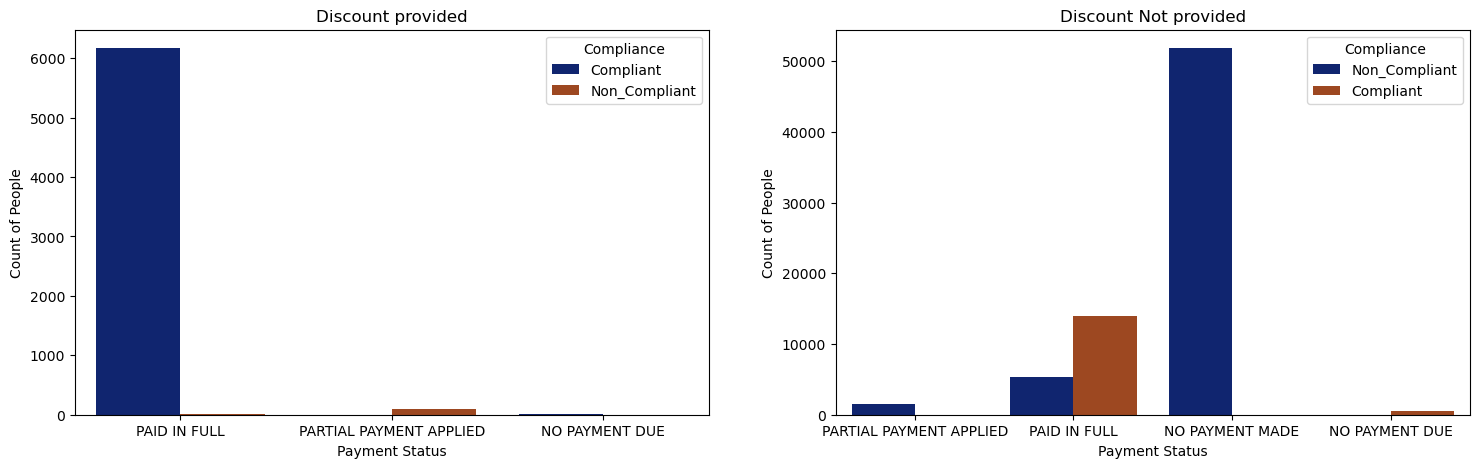

In [53]:

f, axes = plt.subplots(1, 2, figsize=(18,5))

fig.suptitle('Compliance Measure based on discount')

sns.countplot(x="payment_status", hue = 'Compliance',data=D, ax = axes[0])
axes[0].set_title('Discount provided')
axes[0].set(xlabel="Payment Status", ylabel = "Count of People")
sns.countplot(x="payment_status", hue = 'Compliance',data=E,  ax = axes[1])
axes[1].set_title('Discount Not provided')
axes[1].set(xlabel="Payment Status", ylabel = "Count of People")
sns.set_palette('dark')

Text(103.49895833333336, 0.5, 'Discount Amount')

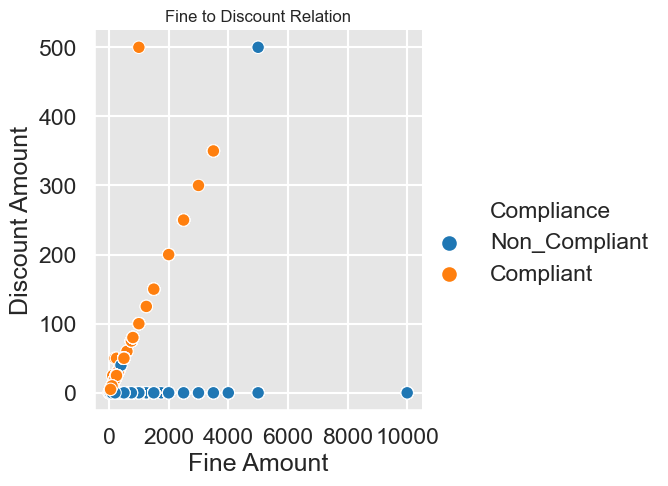

In [82]:

sns.relplot(data = Compliant_dataset_new, x = 'fine_amount', y = 'discount_amount', hue = 'Compliance')
sns.reset_defaults()
plt.title('Fine to Discount Relation')
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.xlabel('Fine Amount')
plt.ylabel('Discount Amount')

In [58]:
#convert all values to lowercase helps standardize city names
Compliant_dataset_new['city'] =Compliant_dataset_new['city'].str.lower()
Compliant_dataset_new['city'] = Compliant_dataset_new['city'].replace('det','detroit')
Compliant_dataset_new['city'] = Compliant_dataset_new['city'].replace(['mendota hts., ','mendota hts.,','mendota hghts.', 'mendota   heights','menndota  heights','mendata  hgt','mendeta height'],'mendota heights')
Compliant_dataset_new['city'] = Compliant_dataset_new['city'].replace('menomonee','menomonee falls')

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

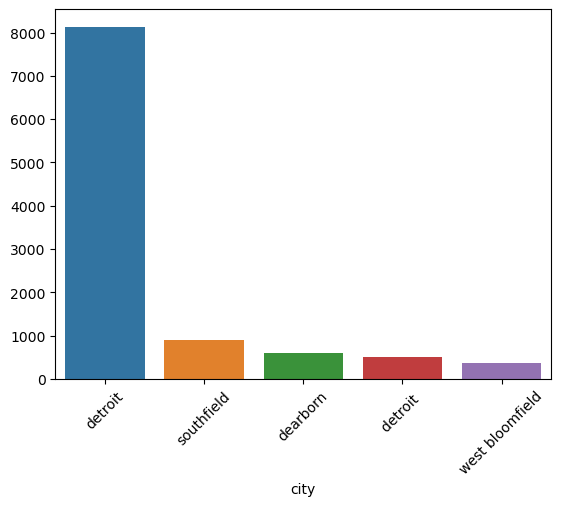

In [66]:
# Count of compliance cases 
Compliant_cities=Compliant_dataset_new[Compliant_dataset_new['Compliance']=='Compliant'].groupby('city')['Compliance'].count()
head = Compliant_cities.sort_values(ascending=False).head(5)
sns.reset_defaults()
sns.barplot(head.index, head.values)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

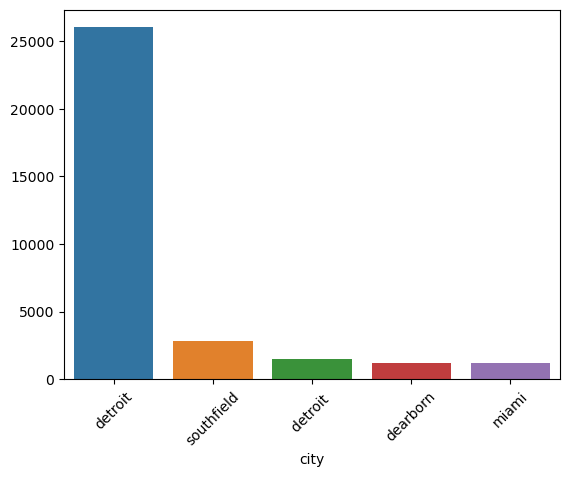

In [67]:
Non_Compliant_cities=Compliant_dataset_new[Compliant_dataset_new['Compliance']=='Non_Compliant'].groupby('city')['Compliance'].count()
#visualize the most 5 Non compliant cities
head1 = Non_Compliant_cities.sort_values(ascending=False).head(5)
sns.barplot(head1.index, head1.values)
plt.xticks(rotation=45)

In [61]:
Compliant_df= pd.DataFrame({'city': Compliant_cities.index,     
                           'Compliant_counts':Compliant_cities.values})

In [62]:
Non_Compliant_df= pd.DataFrame({'city': Non_Compliant_cities.index,     
                           'Non Compliant_counts': Non_Compliant_cities.values})

In [63]:
result = pd.concat([Compliant_df, Non_Compliant_df], axis=1)
result['Compliant_counts'] = result['Compliant_counts'].fillna(0)


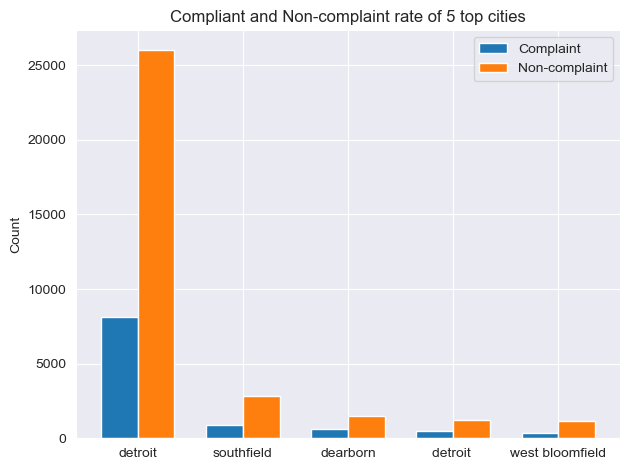

In [69]:
#visualize compliant and non-complaint rate of 5 top cities
sns.reset_defaults()
x = np.arange(len(head.index))  # the label locations
width = 0.35  # the width of the bars
sns.set_style('darkgrid')
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, head.values, width, label='Complaint')
rects2 = ax.bar(x + width/2, head1.values, width, label='Non-complaint')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Compliant and Non-complaint rate of 5 top cities')
ax.set_xticks(x)
ax.set_xticklabels(head.index)
ax.legend()
fig.tight_layout()
plt.show()

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

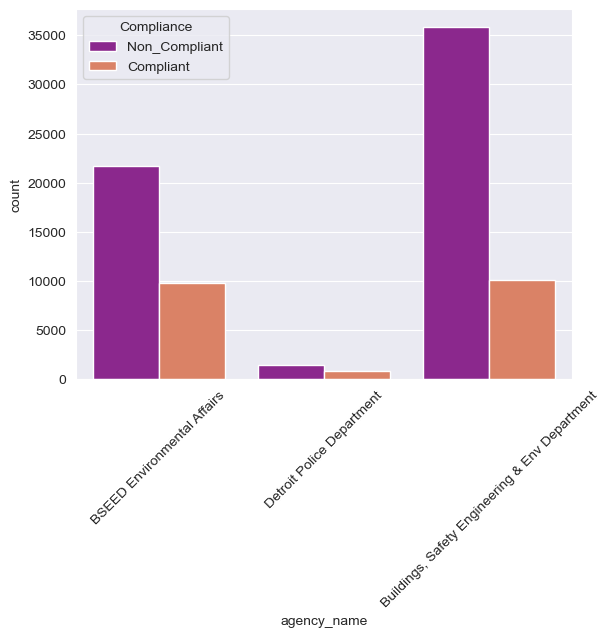

In [65]:
sns.set_style('darkgrid')
sns.countplot(data=Compliant_dataset_new, x="agency_name", hue="Compliance", palette ='plasma')
plt.xticks(rotation=45)

### Feature Importance (Mutual Information)

In [84]:
columns = ['agency_name','inspector_name','violator_name','violation_street_number','violation_street_name','violator_id',
'mailing_address_str_name','city','state','violation_date','ticket_issued_time',
'hearing_date','hearing_time','judgment_date','violation_code','violation_description',
'disposition','fine_amount','admin_fee','state_fee','late_fee','discount_amount','judgment_amount',
'balance_due','payment_date','payment_status','violation_address','Compliance']


In [85]:
Compliant_dataset_new.shape

(79597, 31)

In [86]:
Compliant_dataset_new_labeled  = Compliant_dataset_new.copy()

In [87]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
for i in columns:
    Compliant_dataset_new_labeled[i]= label_encoder.fit_transform(Compliant_dataset_new[i])

In [88]:
Compliant_dataset_new_labeled.head(5)

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violator_id,mailing_address_str_number,mailing_address_str_name,city,state,...,state_fee,late_fee,discount_amount,judgment_amount,balance_due,payment_date,payment_status,violation_address,Compliance,month_gap
332515,0,143,13918,4288,679,0,71,13214,555,23,...,0,0,0,9,81,0,3,24073,1,0
368301,2,24,2926,1094,672,1,1521,6528,555,23,...,0,18,0,37,71,12,2,6560,0,0
368302,1,50,10400,637,188,2,316,11088,1620,10,...,0,0,0,47,298,2276,1,27505,1,9223372036854775228
368303,1,50,10400,637,188,3,316,11088,1620,10,...,0,0,0,47,298,2276,1,27505,1,9223372036854775228
368304,1,50,10400,637,188,4,316,11088,1620,10,...,0,0,0,106,378,2276,1,27505,1,9223372036854775228


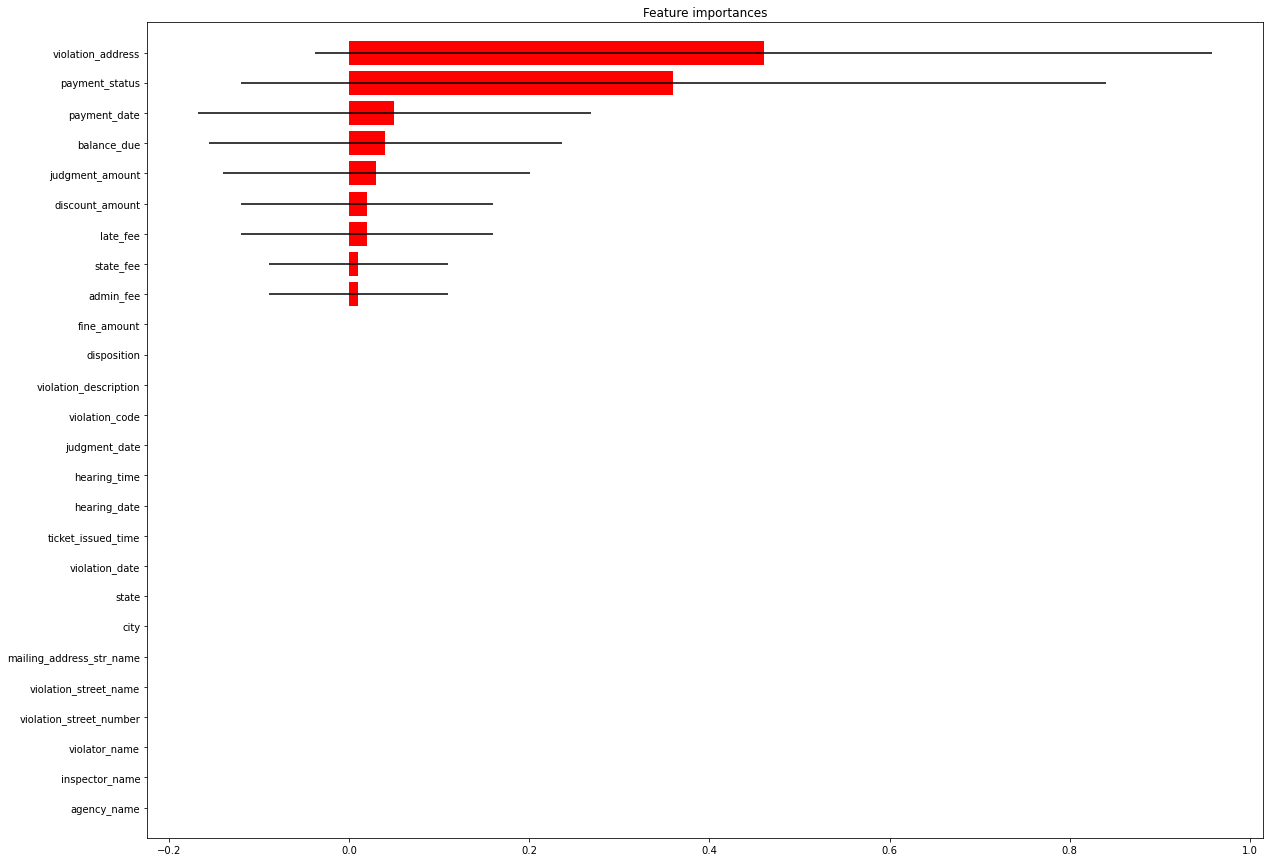

In [105]:

from sklearn.ensemble import AdaBoostClassifier
X = Compliant_dataset_new_labeled.drop(['Compliance','mailing_address_str_number','zip_code','violator_id'],axis =1)
y = Compliant_dataset_new_labeled['Compliance']
# Build a forest and compute the feature importances
forest = AdaBoostClassifier(n_estimators=100)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure(figsize=(20,15))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), X.columns)
plt.ylim([-1, X.shape[1]])
plt.show()

In [106]:
# Checking best features for our label
from sklearn.feature_selection import mutual_info_classif,mutual_info_regression
importances = mutual_info_classif(X,y)


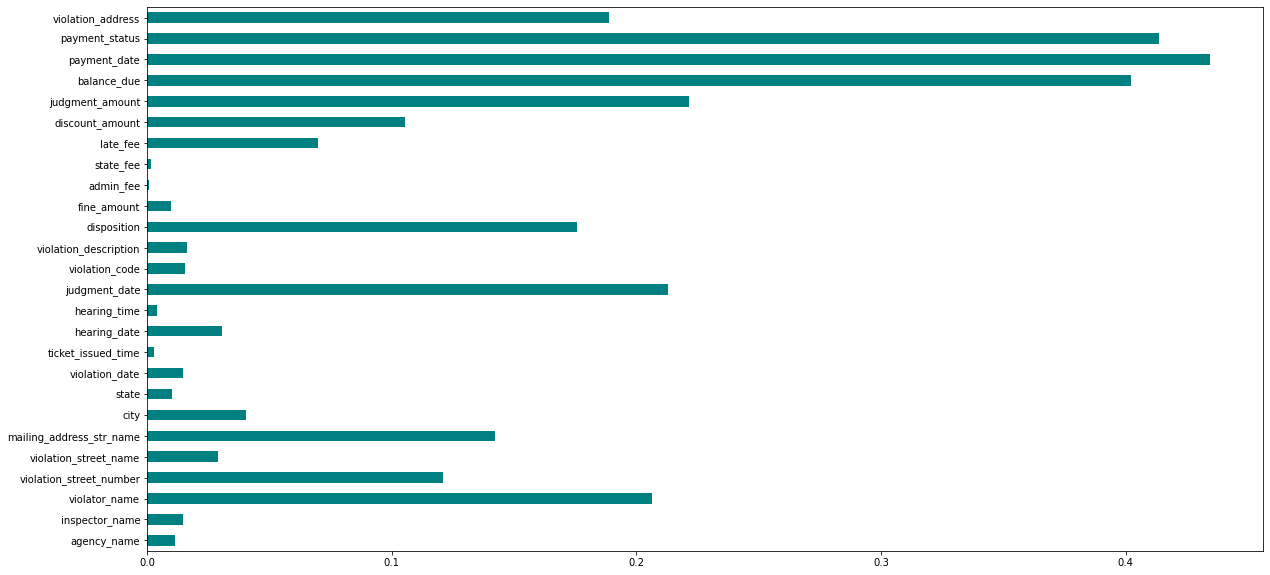

In [107]:
plt.figure(figsize=(20,10)) 
feat_import = pd.Series(importances, X.columns)
feat_import.plot(kind='barh', color ='teal')
plt.show()

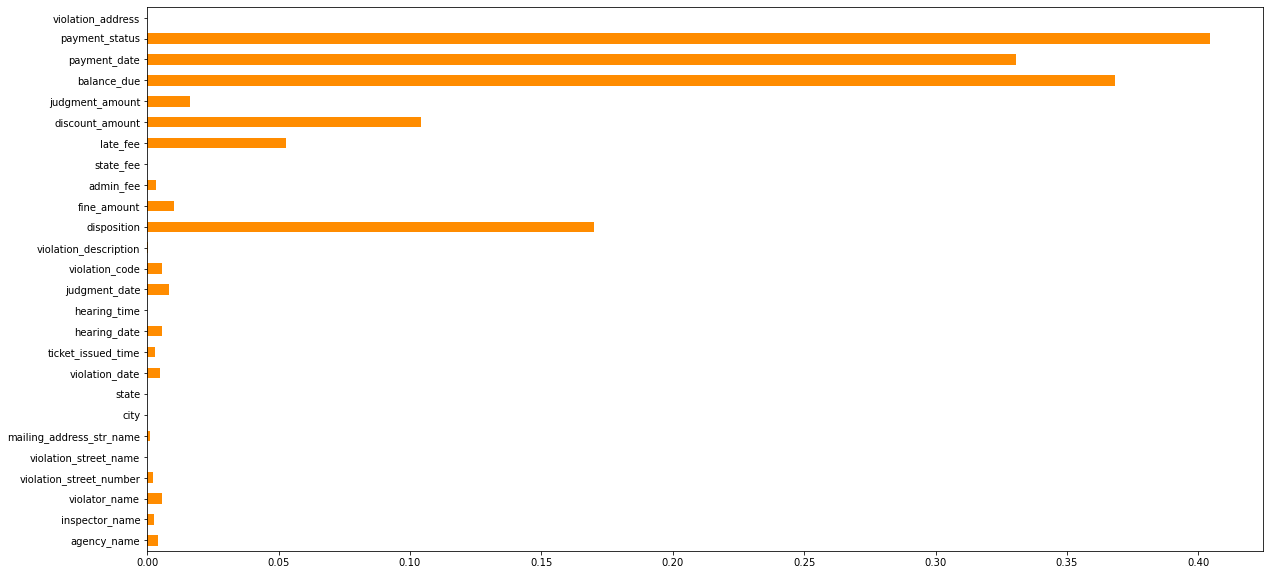

In [108]:
importances1 =  mutual_info_regression(X,y)
plt.figure(figsize=(20,10)) 
feat_import = pd.Series(importances1, X.columns)
feat_import.plot(kind='barh', color ='darkorange')
plt.show()

### Feature Selection

Based on feature importances, selecting the required features for modelling

In [89]:
features = Compliant_dataset_new_labeled[['violator_name','violation_street_name','mailing_address_str_name','judgment_date','disposition','discount_amount','judgment_amount',
'balance_due','late_fee','payment_date','payment_status','violation_address']]
label = Compliant_dataset_new_labeled['Compliance']

### Scaling of datasets

In [90]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()

standardScaler.fit(features)
scaled_features = standardScaler.transform(features)
Features = pd.DataFrame(scaled_features,columns=features.columns)

### Splitting of datasets into train and test sets

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Features,label,test_size=0.2,random_state=10)

### Modelling

In [92]:
# Logistic Regression Model
logicRe=LogisticRegression()
logicRe.fit(X_train,y_train)
pred1 = logicRe.predict(X_test)
A1 = round(accuracy_score(y_test, pred1, normalize = True)*100,2)
print(" Logistic Regression accuracy is",A1)

 Logistic Regression accuracy is 97.69


In [93]:
#Naive Bayes Model
gnb=GaussianNB()
gnb.fit(X_train, y_train)
pred2 =gnb.predict(X_test)
A2 = round(accuracy_score(y_test, pred2, normalize = True)*100,2)
print("Naive-Bayes accuracy without noise is",A2)

Naive-Bayes accuracy without noise is 91.73


In [94]:
from sklearn import svm
SVC=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
SVC.fit(X_train, y_train)
pred3 =SVC.predict(X_test)
A3 = round(accuracy_score(y_test, pred3, normalize = True)*100,2)
print("SVM accuracy without noise is",A3)

SVM accuracy without noise is 97.81


In [95]:
clf_SGD = SGDClassifier(loss='hinge', penalty='l2', max_iter=100)
clf_SGD.fit(X_train, y_train)
pred4 =clf_SGD.predict(X_test)
A4 = round(accuracy_score(y_test, pred4, normalize = True)*100,2)
print("Gradient Boosting Classifier accuracy without noise is",A4)

Gradient Boosting Classifier accuracy without noise is 97.86


### Confusion Matrix

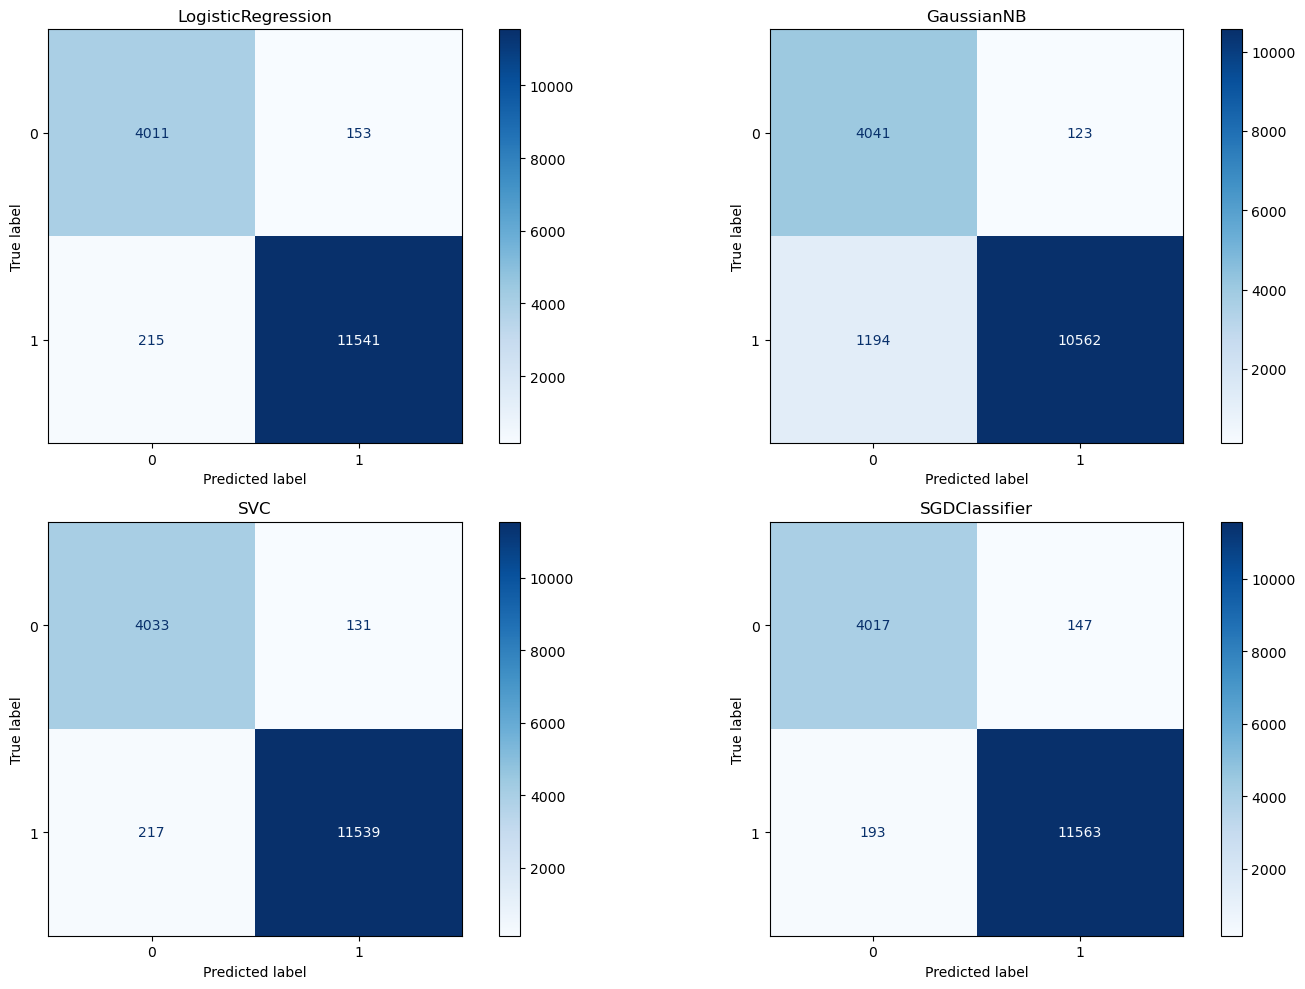

In [97]:
sns.reset_defaults()
from sklearn.metrics import plot_confusion_matrix
classifiers = [logicRe,gnb, SVC, clf_SGD]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

### Classification Reports

In [98]:
print('Classification Report for Logistic Regression')
print(classification_report(y_test,pred1))
print('Classification Report for Naive Bayes')
print(classification_report(y_test,pred2))
print('Classification Report for SVM')
print(classification_report(y_test,pred3))
print('Classification Report for SGD CLassifer')
print(classification_report(y_test,pred4))

Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4164
           1       0.99      0.98      0.98     11756

    accuracy                           0.98     15920
   macro avg       0.97      0.97      0.97     15920
weighted avg       0.98      0.98      0.98     15920

Classification Report for Naive Bayes
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      4164
           1       0.99      0.90      0.94     11756

    accuracy                           0.92     15920
   macro avg       0.88      0.93      0.90     15920
weighted avg       0.93      0.92      0.92     15920

Classification Report for SVM
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4164
           1       0.99      0.98      0.99     11756

    accuracy                           0.98     15920
   macro avg  

### Cross Validation

In [99]:
from sklearn.model_selection import cross_val_score
k = 10

In [100]:
cv_result = cross_val_score(logicRe,X_test,y_test,cv=k) # uses R^2 as score 
print('CV Scores for Logistic Regression is: ',cv_result)
print('CV Average score for Logistic regression is: ',np.sum(cv_result)/k)

CV Scores for Logistic Regression is:  [0.97236181 0.97173367 0.97738693 0.97864322 0.97173367 0.97864322
 0.98052764 0.97801508 0.97487437 0.97675879]
CV Average score for Logistic regression is:  0.9760678391959801


In [101]:
cv_result = cross_val_score(gnb,X_test,y_test,cv=k) # uses R^2 as score 
print('CV Scores for Naive Bayes is: ',cv_result)
print('CV Average score for Naive Bayes is: ',np.sum(cv_result)/k)

CV Scores for Naive Bayes is:  [0.90640704 0.93341709 0.91080402 0.93153266 0.91520101 0.92085427
 0.92148241 0.91834171 0.91520101 0.90829146]
CV Average score for Naive Bayes is:  0.9181532663316583


In [102]:
cv_result = cross_val_score(SVC,X_test,y_test,cv=k) # uses R^2 as score 
print('CV Scores for SVC is: ',cv_result)
print('CV Average score for SVC is: ',np.sum(cv_result)/k)

CV Scores for SVC is:  [0.97047739 0.97487437 0.97927136 0.97864322 0.97424623 0.97613065
 0.97675879 0.97864322 0.97738693 0.9798995 ]
CV Average score for SVC is:  0.9766331658291458


In [103]:
cv_result = cross_val_score(clf_SGD,X_test,y_test,cv=k) # uses R^2 as score 
print('CV Scores for Gradient Boosting Classifier is: ',cv_result)
print('CV Average score for Gradient Boosting Classifier is: ',np.sum(cv_result)/k)

CV Scores for Gradient Boosting Classifier is:  [0.97424623 0.97173367 0.96984925 0.97487437 0.96796482 0.97801508
 0.98115578 0.97613065 0.97550251 0.96796482]
CV Average score for Gradient Boosting Classifier is:  0.9737437185929648


### AUC-ROC Curve

In [104]:
def roCurves(clfList, X_dev, y_dev):
    
    roCurveList = []
    plt.subplots(1, 1, figsize=(5, 5))
    styleList = ['solid','dashed','dotted', 'dashed','dashdot']
    
    for clf, sty in zip(clfList, styleList):
        ax = plt.gca()
        roc = plot_roc_curve(clf, X_dev, y_dev, ax=ax, alpha=0.85, lw=2, linestyle=sty)
        roCurveList.append(roc)
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dotted')
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    return roCurveList

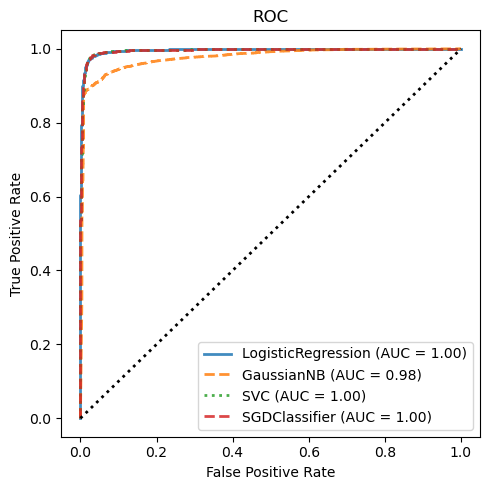

In [106]:
exps = [logicRe, gnb, SVC, clf_SGD]

roCurves(exps, X_test, y_test)

# Save the figure and show
plt.tight_layout()
#plt.savefig('plots/ROCs.png')
plt.show()

#### Hence to conclude, for this dataset Support Vector Classification is model the team would suggest.

#### Other noted highlights through EDA were:
#### --If a certain discount is provided in fine, the chances of person being compliant is very high
#### --If a person is non-compliant, the maximun timeline to expect for him/her to pay is 26 months, after which he can be listed as a permament defaulter
#### --Most non compliance occurs in high fines
